In [1]:
import torch
import random
from torch.utils.data import DataLoader
from smort.data.text_motion_dataset import TextMotionDataset
from smort.data.data_module import InterXDataModule

from smort.models.smort import SMORT
from smort.rifke import feats_to_joints
from smort.data.collate import length_to_mask
from smort.models.text_encoder import TextToEmb

In [2]:
text_motion_dataset = TextMotionDataset(
    "deps/interx/processed/dataset.h5",
)
train_dataloader = DataLoader(
    text_motion_dataset,
    batch_size=1,
    collate_fn=text_motion_dataset.collate_fn,
    shuffle=True,
    # num_workers=7,
    # persistent_workers=True,
)

data_module = InterXDataModule(
    "deps/interx/processed/dataset.h5",
    batch_size=1,
    num_workers=1,
    use_tiny=True,
    return_scene=True,
)
data_module.setup("train")

# next(iter(train_dataloader))

# from smort.renderer.matplotlib import SceneRenderer

# sample = data_module.dataset.collate_fn(
#     [
#         data_module.get_scene(
#             random.randint(0, len(text_motion_dataset)), print_scene_text=True
#         )
#     ]
# )

Scene found: G016T007A036R007
Two people face each other, with one attempting to cover the other person's mouth using both hands. However, the other person notices and steps back, using his/her own hands to prevent it.
Two individuals confront each other, as one endeavors to obstruct the other person's mouth by employing both hands. Nevertheless, the other individual perceives the situation and retreats, utilizing his/her own hands to avert it.
Two people sit facing each other, and one person extends his/her left hand to cover the other person's mouth.


Frame 387: Color (0.20141951854607287, 0.3609024604102455, 0.6001268732065045)
Frame 347: Color (0.26146840790732284, 0.3976545063237326, 0.6019336539483473)
Frame 307: Color (0.3278941704750771, 0.4356819268785206, 0.5973635614836859)
Frame 267: Color (0.4006968062493358, 0.4749847220746094, 0.5864165958125199)
Frame 227: Color (0.484041210543097, 0.5163958709745988, 0.5649278616218515)
Frame 187: Color (0.5473914603039642, 0.5538081889680093, 0.563433281964077)
Frame 147: Color (0.5362319321925816, 0.57631855138697, 0.6364484801785525)
Frame 107: Color (0.5314492772877033, 0.6001042884472314, 0.7030868051865236)
Frame 67: Color (0.5330434955893293, 0.6251654001487937, 0.7633482569879904)
Frame 27: Color (0.5410145870974599, 0.651501886491657, 0.8172328355829526)
Frame 387: Color (0.6001268732065045, 0.20141951854607287, 0.4406439313423318)
Frame 347: Color (0.6019336539483473, 0.26146840790732284, 0.4657475555319375)
Frame 307: Color (0.5973635614836859, 0.3278941704750771, 0.4895758

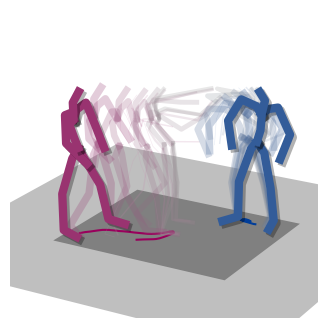

In [3]:
# SceneRenderer().render_image(
#     [
#         feats_to_joints(
#             torch.from_numpy(
#                 text_motion_dataset.reverse_norm(sample["reactor_x_dict"]["x"][0])
#             )
#         ),
#         feats_to_joints(
#             torch.from_numpy(
#                 text_motion_dataset.reverse_norm(sample["actor_x_dict"]["x"][0])
#             )
#         ),
#     ],
#     step_frame=40,
#     highlight_frames=[],
# )

In [4]:
# mean, std = text_motion_dataset.get_mean_std()
# assert type(mean) == torch.Tensor and type(std) == torch.Tensor
# model = SMORT(mean, std)

# trainer = Trainer(
#     accelerator="cpu", max_epochs=10, fast_dev_run=False, num_sanity_val_steps=0
# )

# trainer.fit(model, data_module)

In [5]:
# import wandb

# run = wandb.init()
# artifact = run.use_artifact("rohit-k-kesavan/smort/model-b18rnvib:v1", type="model")
# artifact_dir = artifact.download()

In [6]:
mean, std = text_motion_dataset.get_mean_std()
scene_idx = random.randint(0, 2000)
print(f"Scene: {scene_idx}")
# success: G005T000A000R000, G005T004A020R002, G001T000A002R010
# success: 430, 1726, 253, 642, 424, 1676, 982
# failure: 277, 1155, 292, 613
sample = data_module.dataset.collate_fn(
    [data_module.get_scene(scene_idx, print_scene_text=True)]
)
model = SMORT.load_from_checkpoint(
    "artifacts/model-b18rnvib:v1/model.ckpt",
    data_mean=mean,
    data_std=std,
)

encoded = model.motion_encoder(sample["actor_x_dict"])

dists = encoded.unbind(1)
mu, logvar = dists
latent_vectors = mu
motion = text_motion_dataset.reverse_norm(
    model.motion_decoder(
        {
            "z": latent_vectors,
            "mask": sample["reactor_x_dict"]["mask"],
        },
        sample["actor_x_dict"],
    ).squeeze(dim=0)
)
from smort.renderer.matplotlib import SceneRenderer

SceneRenderer().render_image(
    [
        feats_to_joints(torch.from_numpy(motion)),
        feats_to_joints(
            torch.from_numpy(
                text_motion_dataset.reverse_norm(sample["actor_x_dict"]["x"][0])
            )
        ),
    ]
)

Scene: 207
Scene found: G002T000A003R017
The first person grabs the second person's right elbow with their right hand, stopping them from walking forward.
The first person stands to the left and in front of the second person, takes a step forward, and extends his/her right hand to grasp the left upper arm of the second person.
One person reaches out his/her right hand and grabs the left upper arm of the other person.


RuntimeError: Error(s) in loading state_dict for SMORT:
	Unexpected key(s) in state_dict: "motion_decoder.context_proj.0.weight", "motion_decoder.context_proj.0.bias", "motion_decoder.context_proj.2.weight", "motion_decoder.context_proj.2.bias", "motion_decoder.context_proj.4.weight", "motion_decoder.context_proj.4.bias". 